## Machine Learning Model Training

**Dataset path:** `../data/raw/StressLevelDataset.csv`

In [1]:
#================================================================
# Add all the libraries imports needed in the project here
#================================================================
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.feature_selection import VarianceThreshold
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Use imblearn Pipeline for pipelines WITH a sampler step
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from pathlib import Path
import sys
# Point to the project root (adjust parents[1] to parents[2] if your notebook is deeper)
PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

#================================================================
# Imports custom preprocessing functions from 'functions.py'
#================================================================

from lib.functions import (is_binary_like,
                        _pretty_p,
                        evaluate_classifier,
                        run_models_with_importances,
                        feature_importances_dataframe
                        )

#================================================================
#  Initialize config
#================================================================
config = None
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")
    
# =============================================================================
# DATA LOADING
# =============================================================================
df = pd.read_csv(config['output_data']['file1'])


**1) Quick checks**

In [2]:
display(df.head())
display(df.shape)
display(df.dtypes)
display(df.isna().sum())


,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,safety,basic_needs,academic_performance,study_load,teacher_student_relationship,peer_pressure,extracurricular_activities,bullying,stress_level
0,20,0,11,2,1,2,4,2,3,3,2,3,2,3,3,3,2,1
1,8,1,15,5,3,1,4,3,1,2,2,1,4,1,4,5,5,2
2,18,1,14,2,1,2,2,2,2,3,2,2,3,3,3,2,2,1
3,12,1,15,4,3,1,3,4,2,2,2,2,4,1,4,4,5,2
4,28,0,7,2,3,5,1,3,2,4,3,4,3,1,5,0,5,1


(793, 18)

self_esteem                     int64
mental_health_history           int64
depression                      int64
headache                        int64
blood_pressure                  int64
sleep_quality                   int64
breathing_problem               int64
noise_level                     int64
living_conditions               int64
safety                          int64
basic_needs                     int64
academic_performance            int64
study_load                      int64
teacher_student_relationship    int64
peer_pressure                   int64
extracurricular_activities      int64
bullying                        int64
stress_level                    int64
dtype: object

self_esteem                     0
mental_health_history           0
depression                      0
headache                        0
blood_pressure                  0
sleep_quality                   0
breathing_problem               0
noise_level                     0
living_conditions               0
safety                          0
basic_needs                     0
academic_performance            0
study_load                      0
teacher_student_relationship    0
peer_pressure                   0
extracurricular_activities      0
bullying                        0
stress_level                    0
dtype: int64

**2) Detect numeric, binary-like, and categorical columns**

In [3]:
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
binary_like = [c for c in num_cols_all if is_binary_like(df[c])]
num_cols = [c for c in num_cols_all if c not in binary_like]
print('Numeric (non-binary-like):', num_cols)
print('Binary-like:', binary_like)
print('Categorical:', cat_cols)

Numeric (non-binary-like): ['self_esteem', 'depression', 'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem', 'noise_level', 'living_conditions', 'safety', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship', 'peer_pressure', 'extracurricular_activities', 'bullying', 'stress_level']
Binary-like: ['mental_health_history']
Categorical: []


**3) Train/Test split & preprocessing**

In [4]:
target = 'stress_level'
X = df.drop(columns=[target])
y = df[target]

num_cols_all = X.select_dtypes(include=[np.number]).columns.tolist()
binary_like = [c for c in num_cols_all if is_binary_like(df[c])]
num_cols = [c for c in num_cols_all if c not in binary_like]
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape

((634, 17), (159, 17))

# KNN (Supervised ML)

**4) Fit KNN and evaluate**

In [5]:
knn = KNeighborsClassifier(n_neighbors=5)
pipe = Pipeline([('prep', preprocess), ('model', knn)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
evaluate_classifier(y_test, y_pred, title='KNN (k=5)')      # accuracy + confusion + per-class precision/recall/F1 

for k in [3,5,7,9,11]:
    m = Pipeline([('prep', preprocess), ('model', KNeighborsClassifier(n_neighbors=k, weights='distance'))])
    m.fit(X_train, y_train)
    yp = m.predict(X_test)
    print(f'k={k}: Acc={round(accuracy_score(y_test, yp),4)}')
    
print('')

for k in [3,5,7,9,11]:
    m = Pipeline([('prep', preprocess), ('model', KNeighborsClassifier(n_neighbors=k, weights='distance'))])
    cv = cross_val_score(m, X_train, y_train, cv=5, scoring='accuracy').mean()
    print(f'k={k}: CV accuracy={cv:.4f}')


=== KNN (k=5) ===
Accuracy: 0.956

Confusion matrix:
[[61  2  1]
 [ 0 64  0]
 [ 0  4 27]]

Classification report:
              precision    recall  f1-score   support

           0     1.0000    0.9531    0.9760        64
           1     0.9143    1.0000    0.9552        64
           2     0.9643    0.8710    0.9153        31

    accuracy                         0.9560       159
   macro avg     0.9595    0.9414    0.9488       159
weighted avg     0.9585    0.9560    0.9558       159

k=3: Acc=0.956
k=5: Acc=0.956
k=7: Acc=0.956
k=9: Acc=0.956
k=11: Acc=0.956

k=3: CV accuracy=0.9479
k=5: CV accuracy=0.9432
k=7: CV accuracy=0.9432
k=9: CV accuracy=0.9416
k=11: CV accuracy=0.9416


**5) Simple pre-selection (VarianceThreshold) & Save pipeline**

In [6]:
vt = VarianceThreshold(threshold=0.0)
vt_pipe = Pipeline([('prep', preprocess), ('vt', vt)])
Xt = vt_pipe.fit_transform(X_train)
print('Transformed shape:', Xt.shape)

clf = Pipeline([('prep', preprocess), ('model', KNeighborsClassifier(n_neighbors=5, weights='distance'))])
clf.fit(X_train, y_train)
with open('stress_pipeline.pkl','wb') as f:
    pickle.dump(clf, f)
print('Saved stress_pipeline.pkl')

Transformed shape: (634, 17)
Saved stress_pipeline.pkl


# Supervised ML (Core Models and Metrics)

**6) Train Logistic Regression, KNN, Decision Tree**

In [7]:
models = {
    'KNN(k=5)': KNeighborsClassifier(n_neighbors=5, weights='distance'),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

results = run_models_with_importances(
    models=models,
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10,
    plot=False,
    save_csv=False
)

=== KNN(k=5) ===
Accuracy: 0.956

Confusion matrix:
[[61  2  1]
 [ 0 64  0]
 [ 0  4 27]]

Classification report:
              precision    recall  f1-score   support

           0     1.0000    0.9531    0.9760        64
           1     0.9143    1.0000    0.9552        64
           2     0.9643    0.8710    0.9153        31

    accuracy                         0.9560       159
   macro avg     0.9595    0.9414    0.9488       159
weighted avg     0.9585    0.9560    0.9558       159

KNN(k=5): no native feature_importances_ or coef_ (skipping top-features).

=== LogisticRegression ===
Accuracy: 0.9623

Confusion matrix:
[[62  2  0]
 [ 0 64  0]
 [ 2  2 27]]

Classification report:
              precision    recall  f1-score   support

           0     0.9688    0.9688    0.9688        64
           1     0.9412    1.0000    0.9697        64
           2     1.0000    0.8710    0.9310        31

    accuracy                         0.9623       159
   macro avg     0.9700    0.9466 

,feature,coef_0,coef_1,coef_2,abs_mean_coef
3,num__blood_pressure,0.835506,-1.957408,1.121901,1.304938
12,num__teacher_student_relationship,0.752710,-1.170542,0.417832,0.780361
9,num__basic_needs,1.126913,-0.581263,-0.545650,0.751276
0,num__self_esteem,0.915193,-0.055341,-0.859853,0.610129
13,num__peer_pressure,0.188761,-0.759971,0.571210,0.506647
14,num__extracurricular_activities,0.652649,-0.731472,0.078823,0.487648
2,num__headache,-0.514103,-0.096997,0.611100,0.407400
10,num__academic_performance,0.539981,-0.435837,-0.104144,0.359987
1,num__depression,-0.000535,0.500332,-0.499797,0.333554
6,num__noise_level,0.014097,-0.466719,0.452622,0.311146


=== DecisionTree ===
Accuracy: 0.9748

Confusion matrix:
[[62  0  2]
 [ 0 64  0]
 [ 1  1 29]]

Classification report:
              precision    recall  f1-score   support

           0     0.9841    0.9688    0.9764        64
           1     0.9846    1.0000    0.9922        64
           2     0.9355    0.9355    0.9355        31

    accuracy                         0.9748       159
   macro avg     0.9681    0.9681    0.9680       159
weighted avg     0.9748    0.9748    0.9748       159


Top 10 features for DecisionTree:


,feature,importance
3,num__blood_pressure,0.550474
9,num__basic_needs,0.352428
13,num__peer_pressure,0.027109
15,num__bullying,0.024114
4,num__sleep_quality,0.011346
14,num__extracurricular_activities,0.010638
2,num__headache,0.007901
5,num__breathing_problem,0.004893
6,num__noise_level,0.003950
7,num__living_conditions,0.002634


**6.1) Uniform comparison table**

In [8]:
rows = []
for name, est in models.items():
    pipe = Pipeline([('prep', preprocess), ('model', est)])
    pipe.fit(X_train, y_train)
    yp = pipe.predict(X_test)
    rows.append({
        'model': name,
        'accuracy': accuracy_score(y_test, yp),
        'balanced_acc': balanced_accuracy_score(y_test, yp),
        'macro_f1': f1_score(y_test, yp, average='macro')
    })
pd.DataFrame(rows).sort_values('macro_f1', ascending=False)

,model,accuracy,balanced_acc,macro_f1
2,DecisionTree,0.974843,0.968078,0.968037
1,LogisticRegression,0.962264,0.946573,0.956494
0,KNN(k=5),0.955975,0.941364,0.948826


# Ensembles (Random Forest, Gradient Boosting and AdaBoost)

**7) Fit and evaluate ensembles**

In [9]:
# 1) RandomForestClassifier
results_base = run_models_with_importances(
    models={'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10,
    plot=False,
    save_csv=True
)
# 2) GradientBoostingClassifier
results_base = run_models_with_importances(
    models={'Gradient Boosting': GradientBoostingClassifier(random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10,
    plot=False,
    save_csv=True
)
# 3) AdaBoostClassifier
results_base = run_models_with_importances(
    models={'AdaBoost': AdaBoostClassifier(n_estimators=200, learning_rate=0.5, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10,
    plot=False,
    save_csv=True
)

=== Random Forest ===
Accuracy: 0.9748

Confusion matrix:
[[62  1  1]
 [ 0 64  0]
 [ 0  2 29]]

Classification report:
              precision    recall  f1-score   support

           0     1.0000    0.9688    0.9841        64
           1     0.9552    1.0000    0.9771        64
           2     0.9667    0.9355    0.9508        31

    accuracy                         0.9748       159
   macro avg     0.9740    0.9681    0.9707       159
weighted avg     0.9755    0.9748    0.9748       159


Top 10 features for Random Forest:


,feature,importance
3,num__blood_pressure,0.159341
9,num__basic_needs,0.133852
2,num__headache,0.112886
1,num__depression,0.095887
10,num__academic_performance,0.085113
13,num__peer_pressure,0.072666
4,num__sleep_quality,0.072173
0,num__self_esteem,0.050872
12,num__teacher_student_relationship,0.048048
8,num__safety,0.044729


=== Gradient Boosting ===
Accuracy: 0.9686

Confusion matrix:
[[62  1  1]
 [ 0 63  1]
 [ 1  1 29]]

Classification report:
              precision    recall  f1-score   support

           0     0.9841    0.9688    0.9764        64
           1     0.9692    0.9844    0.9767        64
           2     0.9355    0.9355    0.9355        31

    accuracy                         0.9686       159
   macro avg     0.9629    0.9629    0.9629       159
weighted avg     0.9686    0.9686    0.9686       159


Top 10 features for Gradient Boosting:


,feature,importance
3,num__blood_pressure,0.337381
9,num__basic_needs,0.315463
13,num__peer_pressure,0.186979
2,num__headache,0.058938
4,num__sleep_quality,0.025863
0,num__self_esteem,0.012861
6,num__noise_level,0.009567
15,num__bullying,0.009424
10,num__academic_performance,0.008027
5,num__breathing_problem,0.007906


=== AdaBoost ===
Accuracy: 0.9623

Confusion matrix:
[[62  1  1]
 [ 1 63  0]
 [ 3  0 28]]

Classification report:
              precision    recall  f1-score   support

           0     0.9394    0.9688    0.9538        64
           1     0.9844    0.9844    0.9844        64
           2     0.9655    0.9032    0.9333        31

    accuracy                         0.9623       159
   macro avg     0.9631    0.9521    0.9572       159
weighted avg     0.9626    0.9623    0.9621       159


Top 10 features for AdaBoost:


,feature,importance
0,num__self_esteem,0.171816
15,num__bullying,0.142653
1,num__depression,0.120600
3,num__blood_pressure,0.101637
13,num__peer_pressure,0.096972
9,num__basic_needs,0.088981
2,num__headache,0.074649
6,num__noise_level,0.071573
4,num__sleep_quality,0.042489
10,num__academic_performance,0.030125


# Hyperparameter Tuning

**8) Tuning RandomForest, GradientBoosting and AdaBoost (GridSearchCV)**

**RandomForestClassifier**

In [10]:
rf_baseline  = Pipeline([('prep', preprocess), ('model', RandomForestClassifier(random_state=42))])
param_grid = {
    'model__n_estimators': [50, 500],
    'model__max_depth': [10, 50],
    'model__min_samples_split': [4, 16],
    'model__max_leaf_nodes': [250, 1000],
    'model__max_features': ["sqrt", "log2"]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_rf = GridSearchCV(rf_baseline, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
gs_rf.fit(X_train, y_train)
print('Best params (RF):', gs_rf.best_params_)
best_rf = gs_rf.best_estimator_

best_rf.fit(X_train, y_train)
pred = best_rf.predict(X_test)
print('Test accuracy (best tuned RF):', round(accuracy_score(y_test, pred),4))

Best params (RF): {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': 250, 'model__min_samples_split': 4, 'model__n_estimators': 500}
Test accuracy (best tuned RF): 0.9748


**GradientBoostingClassifier**

In [11]:
gb_baseline  = Pipeline([('prep', preprocess), ('model', GradientBoostingClassifier(random_state=42))])
param_grid = {
    'model__n_estimators': [50, 500],
    'model__learning_rate': [0.05, 1.0],
    'model__max_depth': [10, 50],
    'model__min_samples_split': [4, 16],
    'model__max_leaf_nodes': [250, 1000],
    'model__max_features': ["sqrt", "log2"]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_gbc = GridSearchCV(gb_baseline, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
gs_gbc.fit(X_train, y_train)
print('Best params (Grid):', gs_gbc.best_params_)
best_gbc = gs_gbc.best_estimator_

best_gbc.fit(X_train, y_train)
pred = best_gbc.predict(X_test)
print('Test accuracy (best tuned GB):', round(accuracy_score(y_test, pred),4))

Best params (Grid): {'model__learning_rate': 0.05, 'model__max_depth': 50, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': 250, 'model__min_samples_split': 4, 'model__n_estimators': 500}
Test accuracy (best tuned GB): 0.9748


**AdaBoostClassifier**

In [12]:
ada_baseline  = Pipeline([('prep', preprocess), ('model', AdaBoostClassifier(random_state=42))])
param_grid = {
    'model__n_estimators': [50, 500],
    'model__learning_rate': [0.05, 1.0]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_ada = GridSearchCV(ada_baseline, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
gs_ada.fit(X_train, y_train)
print("AdaBoost best params:", gs_ada.best_params_)
best_ada = gs_ada.best_estimator_

best_ada.fit(X_train, y_train)
pred = best_ada.predict(X_test)
print('Test accuracy (best tuned ADA):', round(accuracy_score(y_test, pred),4))

AdaBoost best params: {'model__learning_rate': 0.05, 'model__n_estimators': 500}
Test accuracy (best tuned ADA): 0.956


# Imbalanced Data (Multi-class)

**9) Class distribution**

In [13]:
print(y_train.value_counts(normalize=True).round(3))
print(y_test.value_counts(normalize=True).round(3))

stress_level
0    0.404
1    0.399
2    0.197
Name: proportion, dtype: float64
stress_level
1    0.403
0    0.403
2    0.195
Name: proportion, dtype: float64


**10) Baseline Logistic Regression and resampling variants**

In [14]:
# 1) Baseline (no resampling) -> sklearn Pipeline
results_base = run_models_with_importances(
    models={'Baseline LogReg': LogisticRegression(max_iter=1000, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10,
    plot=False,
    save_csv=True
)
# 2) Oversample (ROS) -> imblearn Pipeline + RandomOverSampler
results_ros = run_models_with_importances(
    models={'LogReg + ROS': LogisticRegression(max_iter=1000, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    pipeline_cls=ImbPipeline,
    sampler=RandomOverSampler(random_state=42),
    top=10,
    plot=False,
    save_csv=True
)
# 3) Undersample (RUS)
results_rus = run_models_with_importances(
    models={'LogReg + RUS': LogisticRegression(max_iter=1000, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    pipeline_cls=ImbPipeline,
    sampler=RandomUnderSampler(random_state=42),
    top=10,
    plot=False,
    save_csv=True
)
# 4) SMOTE
results_smt = run_models_with_importances(
    models={'LogReg + SMOTE': LogisticRegression(max_iter=1000, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    pipeline_cls=ImbPipeline,
    sampler=SMOTE(random_state=42),
    top=10,
    plot=False,
    save_csv=True
)

=== Baseline LogReg ===
Accuracy: 0.9623

Confusion matrix:
[[62  2  0]
 [ 0 64  0]
 [ 2  2 27]]

Classification report:
              precision    recall  f1-score   support

           0     0.9688    0.9688    0.9688        64
           1     0.9412    1.0000    0.9697        64
           2     1.0000    0.8710    0.9310        31

    accuracy                         0.9623       159
   macro avg     0.9700    0.9466    0.9565       159
weighted avg     0.9637    0.9623    0.9618       159


Top 10 features for Baseline LogReg:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
3,num__blood_pressure,0.835506,-1.957408,1.121901,1.304938
12,num__teacher_student_relationship,0.752710,-1.170542,0.417832,0.780361
9,num__basic_needs,1.126913,-0.581263,-0.545650,0.751276
0,num__self_esteem,0.915193,-0.055341,-0.859853,0.610129
13,num__peer_pressure,0.188761,-0.759971,0.571210,0.506647
14,num__extracurricular_activities,0.652649,-0.731472,0.078823,0.487648
2,num__headache,-0.514103,-0.096997,0.611100,0.407400
10,num__academic_performance,0.539981,-0.435837,-0.104144,0.359987
1,num__depression,-0.000535,0.500332,-0.499797,0.333554
6,num__noise_level,0.014097,-0.466719,0.452622,0.311146


=== LogReg + ROS ===
Accuracy: 0.9623

Confusion matrix:
[[61  2  1]
 [ 0 64  0]
 [ 1  2 28]]

Classification report:
              precision    recall  f1-score   support

           0     0.9839    0.9531    0.9683        64
           1     0.9412    1.0000    0.9697        64
           2     0.9655    0.9032    0.9333        31

    accuracy                         0.9623       159
   macro avg     0.9635    0.9521    0.9571       159
weighted avg     0.9631    0.9623    0.9620       159


Top 10 features for LogReg + ROS:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
3,num__blood_pressure,0.764380,-2.062403,1.298023,1.374935
12,num__teacher_student_relationship,0.829907,-1.266161,0.436255,0.844108
9,num__basic_needs,1.138240,-0.654463,-0.483777,0.758827
0,num__self_esteem,0.876061,-0.044723,-0.831338,0.584040
13,num__peer_pressure,0.207567,-0.807406,0.599839,0.538271
14,num__extracurricular_activities,0.642975,-0.704838,0.061863,0.469892
6,num__noise_level,-0.035585,-0.544794,0.580379,0.386920
2,num__headache,-0.532622,-0.047156,0.579778,0.386519
1,num__depression,-0.049097,0.542623,-0.493526,0.361749
10,num__academic_performance,0.542609,-0.491156,-0.051452,0.361739


=== LogReg + RUS ===
Accuracy: 0.9623

Confusion matrix:
[[62  1  1]
 [ 0 64  0]
 [ 2  2 27]]

Classification report:
              precision    recall  f1-score   support

           0     0.9688    0.9688    0.9688        64
           1     0.9552    1.0000    0.9771        64
           2     0.9643    0.8710    0.9153        31

    accuracy                         0.9623       159
   macro avg     0.9628    0.9466    0.9537       159
weighted avg     0.9624    0.9623    0.9617       159


Top 10 features for LogReg + RUS:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
3,num__blood_pressure,0.671060,-1.931582,1.260522,1.287721
10,num__academic_performance,1.082563,-0.875179,-0.207383,0.721708
1,num__depression,-0.428310,0.970478,-0.542168,0.646985
0,num__self_esteem,0.966875,-0.156779,-0.810097,0.644584
12,num__teacher_student_relationship,0.283353,-0.952529,0.669176,0.635019
6,num__noise_level,0.131706,-0.848320,0.716614,0.565547
13,num__peer_pressure,-0.121130,-0.603339,0.724469,0.482979
15,num__bullying,0.687171,-0.399031,-0.288140,0.458114
16,remainder__mental_health_history,-0.449597,0.640193,-0.190597,0.426796
11,num__study_load,-0.611654,0.303745,0.307909,0.407769


=== LogReg + SMOTE ===
Accuracy: 0.956

Confusion matrix:
[[61  2  1]
 [ 0 64  0]
 [ 2  2 27]]

Classification report:
              precision    recall  f1-score   support

           0     0.9683    0.9531    0.9606        64
           1     0.9412    1.0000    0.9697        64
           2     0.9643    0.8710    0.9153        31

    accuracy                         0.9560       159
   macro avg     0.9579    0.9414    0.9485       159
weighted avg     0.9566    0.9560    0.9554       159


Top 10 features for LogReg + SMOTE:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
3,num__blood_pressure,0.806245,-2.048032,1.241787,1.365355
12,num__teacher_student_relationship,0.880016,-1.282918,0.402902,0.855279
9,num__basic_needs,1.128989,-0.645297,-0.483692,0.752659
0,num__self_esteem,0.994227,-0.031913,-0.962314,0.662818
13,num__peer_pressure,0.174647,-0.871846,0.697198,0.581230
2,num__headache,-0.667639,-0.123973,0.791611,0.527741
14,num__extracurricular_activities,0.716565,-0.771338,0.054773,0.514225
1,num__depression,0.074819,0.559741,-0.634560,0.423040
16,remainder__mental_health_history,-0.436470,0.518972,-0.082502,0.345981
10,num__academic_performance,0.510275,-0.487240,-0.023035,0.340184


**10.1) Evaluate with macro metrics**

In [15]:
# Baseline (no resampling): sklearn Pipeline is fine here
base = Pipeline([
    ('prep', preprocess),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# Oversampling / Undersampling / SMOTE: MUST use imblearn Pipeline
ros = ImbPipeline([
    ('prep', preprocess),
    ('ros', RandomOverSampler(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

rus = ImbPipeline([
    ('prep', preprocess),
    ('rus', RandomUnderSampler(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

smt = ImbPipeline([
    ('prep', preprocess),
    ('smt', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# --- evaluation loop (balanced accuracy + macro F1) ---
for name, pipe in [
    ('Baseline LogReg', base),
    ('LogReg + ROS', ros),
    ('LogReg + RUS', rus),
    ('LogReg + SMOTE', smt)
]:
    pipe.fit(X_train, y_train)          # resampling happens ONLY on train folds
    yp = pipe.predict(X_test)           # test set remains untouched
    print(
        name,
        ' | balanced_acc=', round(balanced_accuracy_score(y_test, yp), 3),
        ' | macro_f1=', round(f1_score(y_test, yp, average="macro"), 3)
    )

Baseline LogReg  | balanced_acc= 0.947  | macro_f1= 0.956
LogReg + ROS  | balanced_acc= 0.952  | macro_f1= 0.957
LogReg + RUS  | balanced_acc= 0.947  | macro_f1= 0.954
LogReg + SMOTE  | balanced_acc= 0.941  | macro_f1= 0.949


## Unsupervised Learning (PCA + Clustering)

**11) PCA (numeric features only)**

In [16]:
num_all = df.select_dtypes(include=[np.number]).columns.tolist()
Xnum = df[num_all].dropna().values
Xnum_scaled = StandardScaler().fit_transform(Xnum)
pca = PCA(n_components=2)
X2 = pca.fit_transform(Xnum_scaled)
print('Explained variance (2 comps):', pca.explained_variance_ratio_.round(3), 'Sum=', round(pca.explained_variance_ratio_.sum(),3))

Explained variance (2 comps): [0.669 0.065] Sum= 0.734


**12) KMeans & Hierarchical clustering on PCA(2)**

In [17]:
km = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_km = km.fit_predict(X2)
agg = AgglomerativeClustering(n_clusters=3)
labels_ag = agg.fit_predict(X2)
print('Silhouette (KMeans):', round(silhouette_score(X2, labels_km), 3))
print('Silhouette (Agglomerative):', round(silhouette_score(X2, labels_ag), 3))

Silhouette (KMeans): 0.823
Silhouette (Agglomerative): 0.817


**2D scatter**

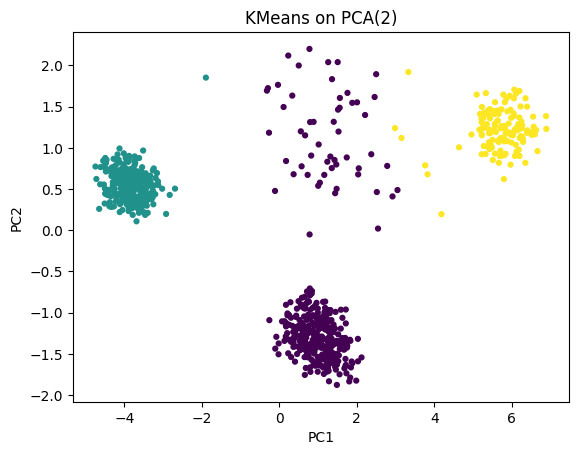

In [18]:
plt.scatter(X2[:,0], X2[:,1], c=labels_km, s=12)
plt.title('KMeans on PCA(2)')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()